In [2]:
#Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import warnings
import time

from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization


In [3]:
#Загрузка данных
def get_sp500_tickers():
    # Ссылка на страницу Wikipedia с перечнем компаний S&P 500
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    sp500_table = pd.read_html(url, header=0)[0]
    tickers = sp500_table['Symbol'].tolist()

    # Обработка символов, которые могут вызвать проблемы (например, замена '.' на '-')
    tickers = [ticker.replace('.', '-') for ticker in tickers]

    return tickers

# Получение списка тикеров
tickers = get_sp500_tickers()

start_date = "2022-01-02"
end_date = "2024-01-22"
warnings.filterwarnings("ignore", category=FutureWarning)
data = yf.download(tickers, start=start_date, end=end_date, threads=True)['Close']

[*********************100%%**********************]  503 of 503 completed


In [4]:
# Обработка данных и формирование вспогательных датафреймов
# Удаляем столбцы, где более 10% данных отсутствуют
threshold = 0.1  # 10% порог
data = data.dropna(thresh=int((1 - threshold) * len(data)), axis=1)

data = data.ffill()

data = data.dropna()

# Формирования недостающих датафреймов
unique_tickers = list(data.columns)
num_tickers = len(unique_tickers)
pairs = list(combinations(data.columns, 2))
line_reg = data.copy()
deviation = data.copy()
relative_deviation = data.copy()
spread_pairs = data.copy()
mean_price = data.copy()
mean_price.loc[:, :] = np.nan
spread_pairs.loc[:, :] = np.nan
line_reg.loc[:, :] = np.nan
deviation.loc[:, :] = np.nan
relative_deviation.loc[:, :] = np.nan
num_tickers

500

In [5]:
def regression(unique_tickers, roll_window):

    # Перевод дат в цифровой формат
    line_reg['DateNumeric'] = data.index.map(pd.Timestamp.toordinal)

    # Создание индексов в качестве признаков
    X = line_reg['DateNumeric'].values.reshape(-1, 1)
    for tiker in unique_tickers:
        mean_price[tiker] = data[tiker].rolling(window=15).mean()
        for index in range(roll_window, len(data)):
            current_date = data.index[index]
            tiker_price = data.at[current_date, tiker]
            # Расчет отклонения от линии регрессии котировок
            numeric_date = current_date.toordinal()
            # Рассчет отклонения от линейной регрессии для каждого тикера
            model = LinearRegression()
            model.fit(X[index-roll_window:index+1], data[tiker][index-roll_window:index+1])
            line_reg.at[current_date, tiker] = model.predict([[numeric_date]])
            deviation.at[current_date, tiker] = tiker_price - line_reg.at[current_date, tiker]
            relative_deviation.at[current_date, tiker] = (tiker_price - line_reg.at[current_date, tiker]) / line_reg.at[current_date, tiker]
        
# Рассчет отклонений от линии регрессии котировок каждого тикера
regression(unique_tickers, 23)

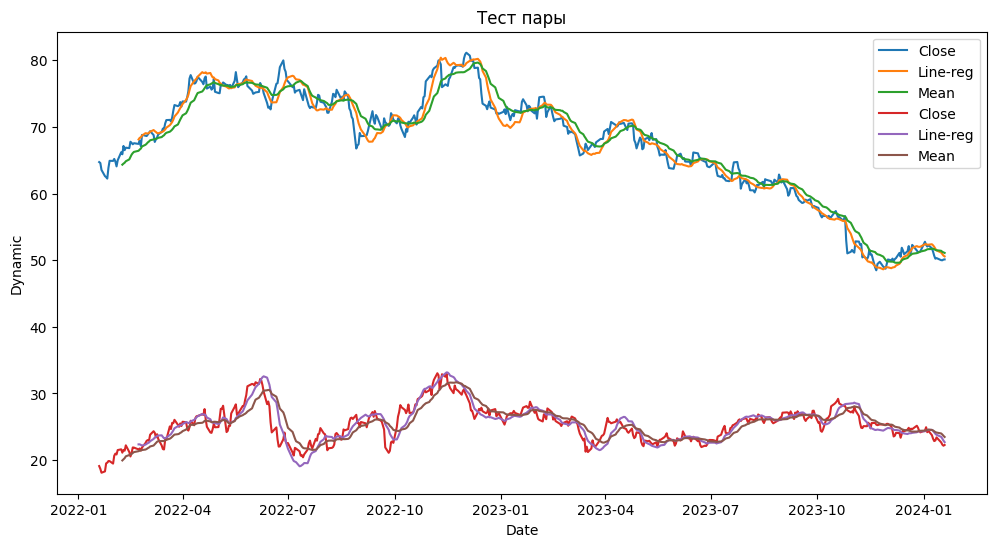

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['BMY'], label='Close')
plt.plot(line_reg.index, line_reg['BMY'], label='Line-reg')
plt.plot(mean_price.index, mean_price['BMY'], label='Mean')
plt.plot(data.index, data['MRO'], label='Close')
plt.plot(line_reg.index, line_reg['MRO'], label='Line-reg')
plt.plot(mean_price.index, mean_price['MRO'], label='Mean')
plt.title('Тест пары')
plt.xlabel('Date')
plt.ylabel('Dynamic')
plt.legend()
plt.show()

In [47]:
window = 28  # Окно для скользящего среднего и стандартного отклонения
roll_window = 23  # Окно для линейной регрессии
coef_entry = 35  # Коэффициент входа в позицию
coef_sell = 1.5  # Коэффициент выхода из позиции
coef_loss = 0.15  # Параметр стоп-лосса
coef_profit = 0.17  # Параметр тейк-профита

options = [window, roll_window, coef_entry, coef_sell, coef_loss, coef_profit]

In [125]:
def pairs_trading(window, delta, coef_entry, coef_sell, coef_loss, coef_profit):

    # Тестируемые тикеры акций
    name_1, name_2 = ('PSX', 'MAR')
    ticker1 = data[name_1]
    ticker2 = data[name_2]

    # Начальные параметры
    initial_capital = 100000    # Стартовый капитал
    max_cash = initial_capital    # Максимально достигнутая сумма
    cash = initial_capital    # Баланс кошелька
    low_shares = 0    # Акции low
    jbht_shares = 0    # Акции jbht
    trade_count = 0   # Счетчик сделок
    window = int(round(window))
    roll_window = int(round(delta * window))
    coef_entry = coef_entry
    coef_sell = coef_sell
    coef_loss = coef_loss
    coef_profit = coef_profit
    flag = True # Индикатор стоп-лосса

    # Объединение данных по дате
    z_test = pd.merge(ticker1, ticker2, left_index=True, right_index=True, how='inner')
    z_test.columns = ['JBHT_Close', 'LOW_Close']

    # Расчет скользящего среднего каждого тикера
    z_test['JBHT_mean'] = z_test['JBHT_Close'].rolling(window=roll_window).mean()
    z_test['LOW_mean'] = z_test['LOW_Close'].rolling(window=roll_window).mean()

    # Расчет логарифмической разности
    z_test['Spread'] = np.log(z_test['LOW_Close']) - np.log(z_test['JBHT_Close'])
    z_test['Mean_spread'] = z_test['Spread'].rolling(window=window).mean()
    z_test['Std_spread'] = z_test['Spread'].rolling(window=window).std()
    z_test['Z-score'] = (z_test['Spread'] - z_test['Mean_spread']) / z_test['Std_spread']
    # Перевод дат в цифровой формат
    z_test['DateNumeric'] = z_test.index.map(pd.Timestamp.toordinal)

    # Создание индексов в качестве признаков
    X = z_test['DateNumeric'].values.reshape(-1, 1)

    for index in range(window, len(z_test)):

        current_date = z_test.index[index]
        jbht_price = z_test.at[current_date, 'JBHT_Close']
        low_price = z_test.at[current_date, 'LOW_Close']
        mean_jbht = z_test.at[current_date, 'JBHT_mean']
        mean_low = z_test.at[current_date, 'LOW_mean']

        # Расчет скользящего среднего и стандартного отклонения для спреда
        std_spread = z_test.at[current_date, 'Std_spread']
        mean_spread = z_test.at[current_date, 'Mean_spread']
        z_score = z_test.at[current_date, 'Z-score']

        # Отклонение цены акции от линии регрессии
        numeric_date = current_date.toordinal()
        # Модель для JBHT
        model_jbht = LinearRegression()
        model_jbht.fit(X[index-roll_window:index], z_test['JBHT_Close'][index-roll_window:index])
        predicted_jbht = model_jbht.predict([[numeric_date]])

        # Модель для LOW
        model_low = LinearRegression()
        model_low.fit(X[index-roll_window:index], z_test['LOW_Close'][index-roll_window:index])
        predicted_low = model_low.predict([[numeric_date]])

        # Расчет отклонения от линии регрессии
        deviation_jbht = jbht_price - predicted_jbht
        deviation_low = low_price - predicted_low

        # Устанавливаем пороги на основе волатильности
        entry = coef_entry * std_spread
        sell = coef_sell * std_spread

        # Торговые сигналы и сделки
        # Покупка спреда
        if z_score < -entry:
            # Длинная позиция по дорогой, короткая по дешевой
            if deviation_low < deviation_jbht:
                if low_shares == 0:
                    low_shares = cash / low_price
                    jbht_shares = -(cash / jbht_price)
                    cash -= low_shares * low_price
                    cash += -jbht_shares * jbht_price
                    trade_count += 1
                elif jbht_shares < 0:
                    delta = (-cash / jbht_price - jbht_shares) * jbht_price
                    low_shares -= delta / low_price
                    jbht_shares = -(cash / jbht_price)
                    trade_count += 1
                elif low_shares < 0:
                    cash += jbht_shares * jbht_price
                    cash += low_shares * low_price
                    low_shares = 0
                    jbht_shares = 0
                    low_shares = cash / low_price
                    jbht_shares = -(cash / jbht_price)
                    trade_count += 1
            # Короткая позиция по LOW, длинная по JBHT
            else: 
                if low_shares == 0:
                    jbht_shares = cash / jbht_price
                    low_shares = -(cash / low_price)
                    cash -= jbht_shares * jbht_price
                    cash += -low_shares * low_price
                    trade_count += 1
                elif low_shares < 0:
                    delta = (-cash / low_price - low_shares) * low_price
                    jbht_shares -= delta / jbht_price
                    low_shares = -(cash / low_price)
                    trade_count += 1
                elif jbht_shares < 0:
                    cash += low_shares * low_price
                    cash += jbht_shares * jbht_price
                    low_shares = 0
                    jbht_shares = 0
                    jbht_shares = cash / jbht_price
                    low_shares = -(cash / low_price)
                    trade_count += 1

        # Покупка спреда
        elif z_score > entry:
            # Короткая позиция по LOW, длинная по JBHT
            if deviation_jbht < deviation_low:
                if low_shares == 0:
                    jbht_shares = cash / jbht_price
                    low_shares = -(cash / low_price)
                    cash -= jbht_shares * jbht_price
                    cash -= low_shares * low_price
                    trade_count += 1
                elif low_shares < 0:
                    delta = (-cash / low_price - low_shares) * low_price
                    jbht_shares -= delta / jbht_price
                    low_shares = -(cash / low_price)
                    trade_count += 1
                elif jbht_shares < 0:
                    cash += low_shares * low_price
                    cash += jbht_shares * jbht_price
                    low_shares = 0
                    jbht_shares = 0
                    jbht_shares = cash / jbht_price
                    low_shares = -(cash / low_price)
                    trade_count += 1
            # Длинная позиция по LOW, короткая по JBHT
            else:
                if low_shares == 0:
                    low_shares = cash / low_price
                    jbht_shares = -(cash / jbht_price)
                    cash -= low_shares * low_price
                    cash += -jbht_shares * jbht_price
                    trade_count += 1
                elif jbht_shares < 0:
                    delta = (-cash / jbht_price - jbht_shares) * jbht_price
                    low_shares -= delta / low_price
                    jbht_shares = -(cash / jbht_price)
                    trade_count += 1
                elif low_shares < 0:
                    cash += jbht_shares * jbht_price
                    cash += low_shares * low_price
                    low_shares = 0
                    jbht_shares = 0
                    low_shares = cash / low_price
                    jbht_shares = -(cash / jbht_price)
                    trade_count += 1

        # Выход из позиции
        elif -sell < z_score < sell and low_shares != 0:
            cash += low_shares * low_price
            cash += jbht_shares * jbht_price
            low_shares = 0
            jbht_shares = 0
            trade_count += 1

        # Установка стоп-лосса
        # Расчет текущей стоимости позиций         
        value_low = low_shares * low_price
        value_jbht = jbht_shares * jbht_price
        total_value = cash + value_low + value_jbht

        if max_cash < cash:
            max_cash = cash
        stop_loss = coef_loss * max_cash

        # Расчет текущей позиции
        current_loss = max_cash - total_value

        # Проверка условий стоп-лосса
        if current_loss > stop_loss:
            # Закрытие всех позиций
            cash += low_shares * low_price
            cash += jbht_shares * jbht_price
            low_shares = 0
            jbht_shares = 0
            trade_count += 1
            max_cash = cash
            #flag = False
            loss_date = current_date
            
        # Установка take-profit
        stop_profit = coef_profit * max_cash

        # Расчет текущего профита
        current_profit = total_value - max_cash

        if current_profit > stop_profit:
            # Закрытие всех позиций
            cash += low_shares * low_price
            cash += jbht_shares * jbht_price
            low_shares = 0
            jbht_shares = 0
            trade_count += 1

        # Если есть шорт позиции, списываем комиссию за день
        if jbht_shares < 0:
            daily_fee = -jbht_shares * jbht_price * 0.13 / 365
            cash -= daily_fee
        elif low_shares < 0:
            daily_fee = -low_shares * low_price * 0.13 / 365
            cash -= daily_fee
        
        z_test.at[current_date, 'Cash'] = cash
                   
    return cash

In [110]:
# Определите диапазоны для каждого параметра
param1_range = np.arange(0.02, 0.2, 0.01)  # Например, от 1 до 10 с шагом 1
param2_range = np.arange(0.02, 0.2, 0.01)  # Еще один пример диапазона

best_score = -np.inf
best_params = {}
results = []
# Перебираем все комбинации параметров
for param1 in param1_range:
    for param2 in param2_range:
        #if param1 >= param2:
        window = 20  # Окно для скользящего среднего и стандартного отклонения
        roll_window = 17  # Окно для линейной регрессии
        coef_entry = 41  # Коэффициент входа в позицию
        coef_sell = 1  # Коэффициент выхода из позиции
        coef_loss = 0.15  # Параметр стоп-лосса
        coef_profit = 0.15  # Параметр тейк-профита

        options = [window, roll_window, coef_entry, coef_sell, param1, param2]

        # Вызываем функцию торговли с текущими параметрами
        score = pairs_trading(('PSX', 'MAR'), options)

        results.append({'params' : (param1, param2), 'cash' : score})

        # Сохраняем параметры, если текущий результат лучше предыдущего
        if score > best_score:
            best_score = score
            best_params = {'param1': param1, 'param2': param2}

print("Лучшие параметры:", best_params)
print("Лучший результат:", best_score)

Лучшие параметры: {'param1': 0.14999999999999997, 'param2': 0.14999999999999997}
Лучший результат: 575509.1332348493


In [126]:
from bayes_opt import BayesianOptimization

results = []

# Определение диапазонов параметров
pbounds = {
    'window': (20, 35),
    'delta': (0.4, 1),
    'coef_entry': (30, 50),
    'coef_sell': (1, 5),
    'coef_loss': (0.02, 0.2),
    'coef_profit': (0.05, 0.2)
}

# Инициализация оптимизатора
optimizer = BayesianOptimization(
    f=pairs_trading,
    pbounds=pbounds,
    random_state=1,
)

# Запуск оптимизации
optimizer.maximize(
    init_points=10, # Количество начальных точек
    n_iter=100,     # Количество шагов оптимизации
)

# Получение оптимальных значений
for i, res in enumerate(optimizer.res):
    results.append({'Итерация' : i, "Result" : res})

# После выполнения процесса оптимизации
best_params = optimizer.max['params']
best_target = optimizer.max['target']

print("Лучшие параметры:", best_params)
print("Лучший результат функции:", best_target)

|   iter    |  target   | coef_e... | coef_loss | coef_p... | coef_sell |   delta   |  window   |
-------------------------------------------------------------------------------------------------
| 1         | 1.322e+05 | 38.34     | 0.1497    | 0.05002   | 2.209     | 0.4881    | 21.39     |
| 2         | 2.487e+05 | 33.73     | 0.0822    | 0.1095    | 3.155     | 0.6515    | 30.28     |
| 3         | 1.552e+05 | 34.09     | 0.1781    | 0.05411   | 3.682     | 0.6504    | 28.38     |
| 4         | 1.586e+05 | 32.81     | 0.05566   | 0.1701    | 4.873     | 0.5881    | 30.38     |
| 5         | 1.293e+05 | 47.53     | 0.181     | 0.06276   | 1.156     | 0.5019    | 33.17     |
| 6         | 1.948e+05 | 31.97     | 0.0958    | 0.1937    | 3.133     | 0.8151    | 24.73     |
| 7         | 1.43e+05  | 43.73     | 0.1702    | 0.05274   | 4.001     | 0.9933    | 31.22     |
| 8         | 1.903e+05 | 35.61     | 0.1621    | 0.06548   | 2.792     | 0.9452    | 24.4      |
| 9         | 1.232e

In [120]:
results

[{'Итерация': 0,
  'Result': {'target': 169142.76894047635,
   'params': {'coef_entry': 38.34044009405148,
    'coef_loss': 0.14965840881958847,
    'coef_profit': 0.050017156222601736,
    'coef_sell': 2.209330290527359,
    'delta': 0.48805353449026784,
    'window': 21.385078921531967}}},
 {'Итерация': 1,
  'Result': {'target': 167726.30691766995,
   'params': {'coef_entry': 33.72520422755342,
    'coef_loss': 0.0822009308677486,
    'coef_profit': 0.1095151211346005,
    'coef_sell': 3.155266936013428,
    'delta': 0.6515167086419769,
    'window': 30.27829250595139}}},
 {'Итерация': 2,
  'Result': {'target': 94388.73597777993,
   'params': {'coef_entry': 38.329251123462164,
    'coef_loss': 0.10116067817012601,
    'coef_profit': 0.1023090154321469,
    'coef_sell': 2.5331212405120502,
    'delta': 0.5081836365086556,
    'window': 21.021950860911115}}},
 {'Итерация': 3,
  'Result': {'target': 141042.09275414594,
   'params': {'coef_entry': 41.95421598809613,
    'coef_loss': 0.07